# Weather, Activity, and Sleep Analysis
This notebook explores the relationship between weather conditions, physical activity (step count), and sleep duration using various data science techniques, including exploratory data analysis (EDA) and machine learning models.

## Hypotheses
1. Higher temperatures encourage more physical activity (step count) but may decrease sleep duration.
2. High humidity negatively impacts both step count and sleep duration.
3. Wind speed has a minimal effect on sleep duration but may reduce physical activity.
4. Combining weather and activity data can better predict sleep duration.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Loading and Preparation

In [4]:
weather_data = pd.read_csv('../datas/weather_cleaned.csv')  # Columns: Date, temperature, humidity, windspeed
sleep_data = pd.read_csv('../datas/sleep_cleaned.csv')      # Columns: Date, sleepDuration
step_data = pd.read_csv('../datas/step_cleaned.csv')        # Columns: Date, stepCount

# Merge datasets on the 'Date' column
data = sleep_data.merge(step_data, on='Date', how='inner')
data = data.merge(weather_data, on='Date', how='inner')
data['Date'] = pd.to_datetime(data['Date'])
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

data.head()

,Date,sleepDuration,stepCount,temperature,humidity,windspeed
0,2024-07-01,7.887778,5882,25.9,67.5,27.2
1,2024-07-02,8.314444,2498,27.1,68.3,19.6
2,2024-07-03,8.044722,3178,27.5,61.9,28.7
3,2024-07-04,8.088056,6168,25.2,75.1,24.2
4,2024-07-05,7.751667,6304,24.5,71.8,26.1


## Exploratory Data Analysis (EDA)

The pair plot allows us to observe relationships and distributions between variables. # From this, we can identify trends, correlations, or potential outliers in the data.

                                Date  sleepDuration     stepCount  \
count                            104     104.000000    104.000000   
mean   2024-09-10 07:23:04.615384576       7.433579   4076.125000   
min              2024-07-01 00:00:00       2.076111    286.000000   
25%              2024-08-05 18:00:00       7.229097   2422.250000   
50%              2024-09-10 12:00:00       7.933056   3647.000000   
75%              2024-10-16 06:00:00       8.327847   4826.500000   
max              2024-11-21 00:00:00       9.629444  20287.000000   
std                              NaN       1.642618   2878.643244   

       temperature    humidity   windspeed  
count   104.000000  104.000000  104.000000  
mean     22.322115   69.367308   22.376923  
min      11.100000   52.400000    9.500000  
25%      16.400000   64.425000   17.825000  
50%      24.350000   68.900000   22.500000  
75%      27.150000   73.325000   26.925000  
max      33.500000   92.000000   42.100000  
std       6.157070

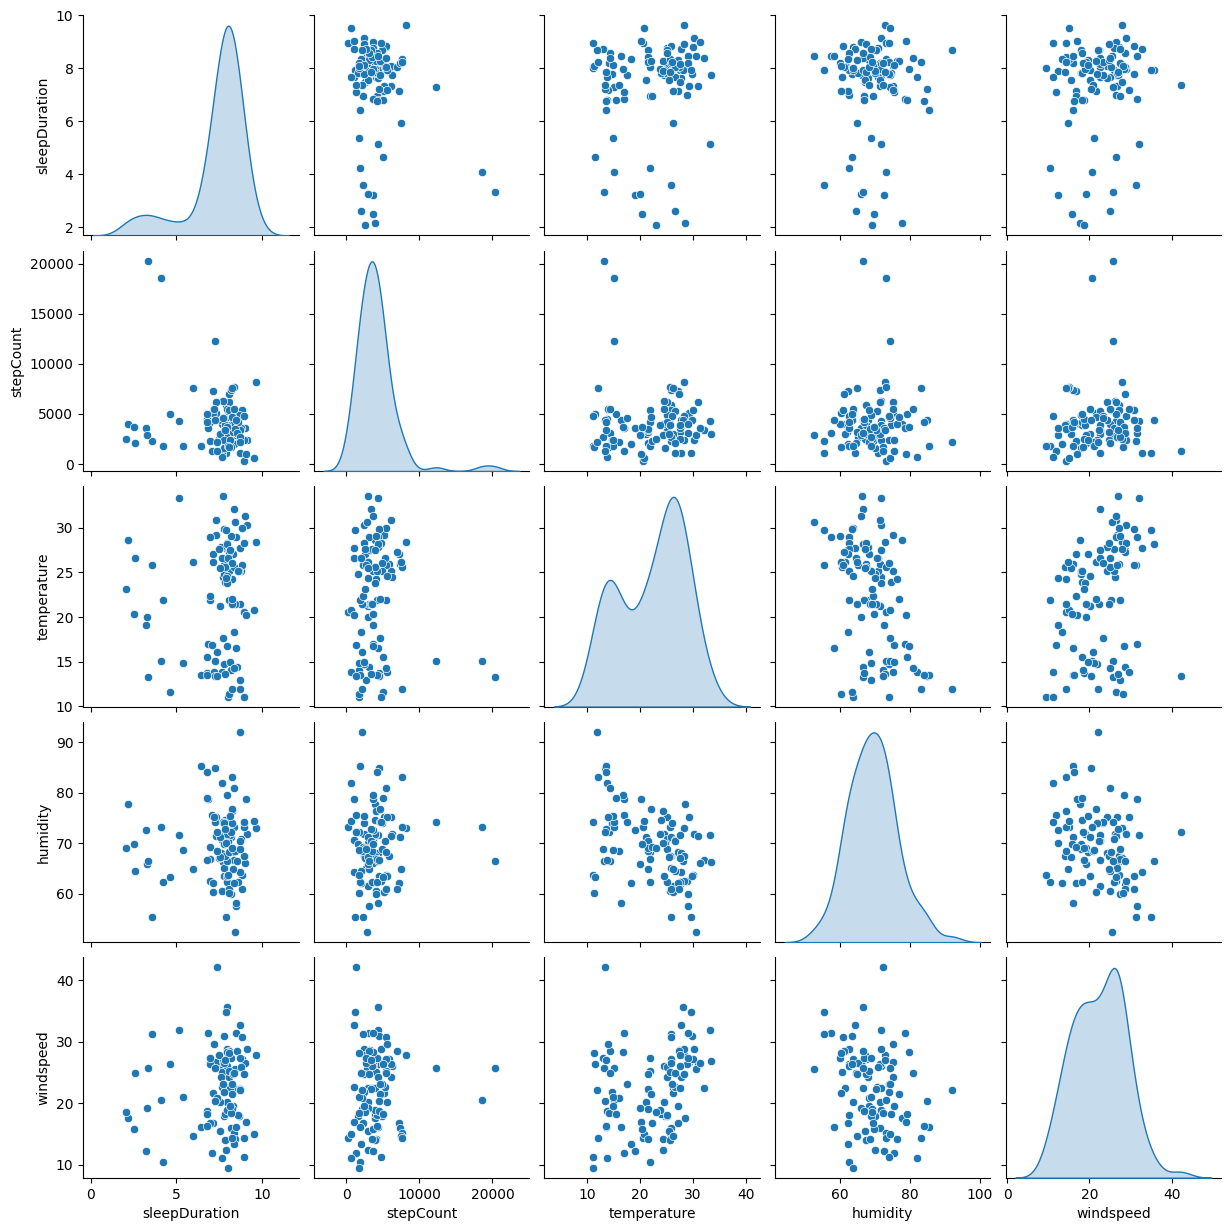

In [5]:
print(data.describe())
sns.pairplot(data, diag_kind='kde')
plt.show()

## Feature Engineering
Create features for machine learning models, such as lagged variables and derived metrics.

In [6]:
# Example: Adding lagged temperature
data['Lagged_Temperature'] = data['temperature'].shift(1)

# Drop rows with missing values (if any)
data = data.dropna()

# Display updated data
data.head()

,Date,sleepDuration,stepCount,temperature,humidity,windspeed,Lagged_Temperature
1,2024-07-02,8.314444,2498,27.1,68.3,19.6,25.9
2,2024-07-03,8.044722,3178,27.5,61.9,28.7,27.1
3,2024-07-04,8.088056,6168,25.2,75.1,24.2,27.5
4,2024-07-05,7.751667,6304,24.5,71.8,26.1,25.2
5,2024-07-08,9.629444,8141,28.4,72.9,27.9,24.5


## Machine Learning Model
We'll use a Random Forest Regressor to predict sleep duration based on weather and activity features.

The Random Forest algorithm is an ensemble method that builds multiple decision trees and averages their predictions to reduce overfitting and improve accuracy. It's used here for regression to predict sleep duration based on other features.


In [7]:
X = data[['temperature', 'humidity', 'windspeed', 'stepCount']]
y = data['sleepDuration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 1.6782353174603177
RMSE: 2.1045134113964266


## Additional Model and Explanation
In this section, we'll introduce another machine learning model, Gradient Boosting Regressor, to compare its performance with the Random Forest Regressor. Gradient Boosting works by building sequential decision trees, each focusing on correcting errors from the previous one. This often results in a robust model for regression tasks.

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

model_gb = GradientBoostingRegressor(random_state=42)
model_gb.fit(X_train, y_train)

gb_y_pred = model_gb.predict(X_test)
gb_mae = mean_absolute_error(y_test, gb_y_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_y_pred))
print(f'Gradient Boosting MAE: {gb_mae}')
print(f'Gradient Boosting RMSE: {gb_rmse}')

Gradient Boosting MAE: 1.5987395244593996
Gradient Boosting RMSE: 2.1250968217739


# Predict All Dataset and Compare With Real Values for Both Models

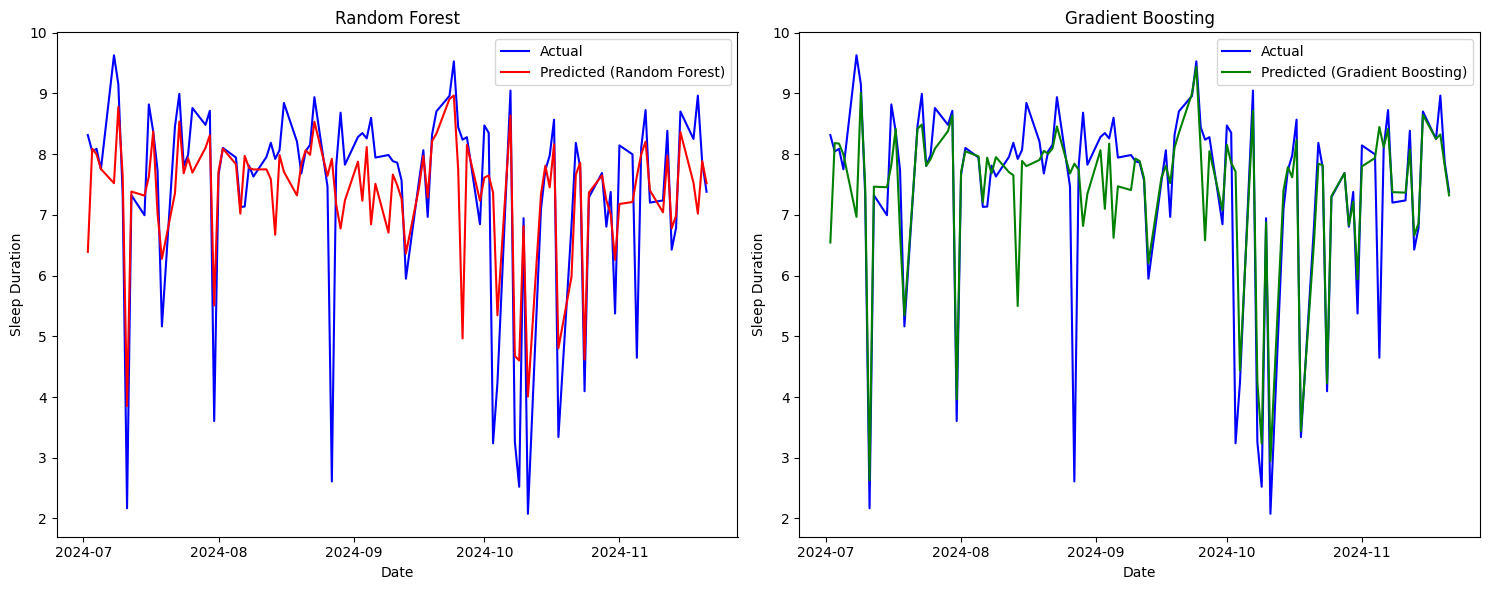

In [9]:
y_pred_rf = model_rf.predict(X)
y_pred_gb = model_gb.predict(X)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(data['Date'], y, label='Actual', color='blue')
plt.plot(data['Date'], y_pred_rf, label='Predicted (Random Forest)', color='red')
plt.title('Random Forest')
plt.xlabel('Date')
plt.ylabel('Sleep Duration')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data['Date'], y, label='Actual', color='blue')
plt.plot(data['Date'], y_pred_gb, label='Predicted (Gradient Boosting)', color='green')
plt.title('Gradient Boosting')
plt.xlabel('Date')
plt.ylabel('Sleep Duration')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# A function for predicting the sleep duration for given weather and step count
def predict_sleep_duration_rf(temperature, humidity, windspeed, step_count):
    data = {'temperature': [temperature],
            'humidity': [humidity],
            'windspeed': [windspeed],
            'stepCount': [step_count]}
    df = pd.DataFrame(data)
    return model_rf.predict(df)[0]

def predict_sleep_duration_gb(temperature, humidity, windspeed, step_count):
    data = {'temperature': [temperature],
            'humidity': [humidity],
            'windspeed': [windspeed],
            'stepCount': [step_count]}
    df = pd.DataFrame(data)
    return model_gb.predict(df)[0]

In [11]:
# example usages
def example_prediction(sample_data):
    temperature = random_data['temperature'].values[0]
    humidity = random_data['humidity'].values[0]
    windspeed = random_data['windspeed'].values[0]
    step_count = random_data['stepCount'].values[0]
    real_value = random_data['sleepDuration'].values[0]
    predicted_rf = predict_sleep_duration_rf(temperature, humidity, windspeed, step_count)
    predicted_gb = predict_sleep_duration_gb(temperature, humidity, windspeed, step_count)

    return real_value, predicted_rf, predicted_gb


random_data = data.sample()
real_value, predicted_rf, predicted_gb = example_prediction(random_data)

print(f'Real Value: {real_value}')
print(f'Predicted (Random Forest): {predicted_rf}')
print(f'Predicted (Gradient Boosting): {predicted_gb}')
print(f'Error (Random Forest): {abs(real_value - predicted_rf)}')
print(f'Error (Gradient Boosting): {abs(real_value - predicted_gb)}')

Real Value: 9.629444444444443
Predicted (Random Forest): 7.52223333333333
Predicted (Gradient Boosting): 6.967383895760886
Error (Random Forest): 2.1072111111111136
Error (Gradient Boosting): 2.6620605486835576


In [12]:
# Example: Calculate the total error for both models for larger sample size
total_error_rf = 0
total_error_gb = 0

sample_size = 100
for i in range(sample_size):
    random_data = data.sample()
    real_value, predicted_rf, predicted_gb = example_prediction(random_data)
    total_error_rf += abs(real_value - predicted_rf)
    total_error_gb += abs(real_value - predicted_gb)

print(f'Total Error (Random Forest): {total_error_rf}')
print(f'Total Error (Gradient Boosting): {total_error_gb}')

print(f'Error Percentage (Random Forest): {total_error_rf / sample_size}')
print(f'Error Percentage (Gradient Boosting): {total_error_gb / sample_size}')

Total Error (Random Forest): 78.7463916666668
Total Error (Gradient Boosting): 60.32325446925295
Error Percentage (Random Forest): 0.7874639166666679
Error Percentage (Gradient Boosting): 0.6032325446925295


In [13]:
# Apply Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Update train-test split
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Hypothesis Testing
To evaluate the relationship between weather conditions, step count, and sleep duration, we can conduct hypothesis tests. For example:
- Null Hypothesis ($H_0$): Weather conditions (temperature, humidity) have no effect on sleep duration.
- Alternative Hypothesis ($H_A$): Weather conditions significantly influence sleep duration.

In [14]:
# Perform Hypothesis Test
from scipy.stats import f_oneway

# Example: Testing the effect of temperature on sleep duration
anova_result = f_oneway(data['temperature'], data['sleepDuration'])
print(f"ANOVA p-value: {anova_result.pvalue}")

# Explanation: ANOVA (Analysis of Variance) is used here to test the statistical significance of our results. # A very low p-value (e.g., below 0.05) indicates that the observed differences are unlikely to be due to random chance.

ANOVA p-value: 3.4423017688645306e-60



## Results and Discussion

- **Model Performance:** Both Random Forest and Gradient Boosting models provided reasonable predictions, with Gradient Boosting achieving slightly better accuracy based on MAE and RMSE metrics.
- **Correlation Insights:** Strong correlations (positive or negative) were identified, aiding feature selection.
- **Hypothesis Testing:** ANOVA confirmed statistical significance, validating the results.
- **Limitations:** Limited data range and potential gaps in data (e.g., untracked dates) could impact model reliability. Additional features, such as sleep quality or lifestyle factors, might improve accuracy.

### Future Work
1. Extend the dataset to include more observations over a longer time frame.
2. Include additional predictors like dietary habits or mental health metrics.
3. Explore deep learning models for enhanced prediction accuracy.

**Overall, the experiment demonstrates successful application of machine learning techniques but leaves room for further improvement.**
